In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import fftpack
from scipy.signal import resample
import warnings

### Data preparation

#### We have record two clip of music Phoenix (about 7-8 seconds). One audio was recorded in a silent environment, and the other one was recorded in the same environment, but with a pen tapping on the table.

In [2]:
# read audio file
# samplerate: audio sampling rate
# data: sampled sound signals
samplerate1, data1 = wavfile.read('../audios/Phoenix_pure.wav')
samplerate2, data2 = wavfile.read('../audios/Phoenix_noise.wav')

In [3]:
# if sample rate different, resample
if samplerate1 != samplerate2:
    if samplerate1 > samplerate2:
        data1 = resample(data1, int(len(data1) * samplerate2 / samplerate1))
        samplerate1 = samplerate2
    else:
        data2 = resample(data2, int(len(data2) * samplerate1 / samplerate2))
        samplerate2 = samplerate1
    warnings.warn("The sample rates of audio1 and audio2 are different. Now we have resampled.")

In [4]:
# get the time length
time_len1 = data1.shape[0] / samplerate1
time_len2 = data2.shape[0] / samplerate2
print(data1.shape, time_len1, samplerate1)
print(data2.shape, time_len2, samplerate2)

(348160,) 7.253333333333333 48000
(386048,) 8.042666666666667 48000


In [5]:
# convert stereo to mono by selecting only one channel
if len(data1.shape) != len(data2.shape):
    raise ValueError("The channel of the audio1 and audio2 must be same.")

if len(data1.shape) == 2:
    data1 = data1[:, 0]
elif len(data1.shape) != 1:
    raise ValueError("The channel of the audio1 is illegal.")

if len(data2.shape) == 2:
    data2 = data1[:, 0]
elif len(data2.shape) != 1:
    raise ValueError("The channel of the audio2 is illegal.")

In [6]:
# cut the same length
if data1.size >= data2.size:
    data1 = data1[:data2.size]
else:
    data2 = data2[:data1.size]

### Use Fast Fourier Transform(FFT) to get the difference of two audios in all frequencies

In [7]:
class FFT:
    def __init__(self, sample_rate, data):
        self.sample_rate = sample_rate
        self.data = data
        self.time_step = 1.0 / self.sample_rate  # the time interval between two samples
        self.time_stamp = np.arange(0, len(self.data)) * self.time_step  # timestamp sequence in seconds
        self.sig_fft = None
        self.amplitude = None
        self.power = None
        self.angle = None
        self.freq = None
        self.amp_freq = None
        self.amp_position_max = None
        self.peak_freq = None
        self.high_freq_fft = None
        self.filtered_sig = None
        self.normalized_sig = None

    def fft_operation(self):
        # complex signal from FFT transformation
        self.sig_fft = fftpack.fft(self.data)

        # the amplitude of the signal
        self.amplitude = np.abs(self.sig_fft)
        # the power spectrum of the signal
        self.power = self.amplitude ** 2
        # the phase angle of the signal
        self.angle = np.angle(self.sig_fft)

        # frequency sequence from FFT transformation
        self.freq = np.abs(fftpack.fftfreq(self.data.size, d=self.time_step))
        # the amplitude and frequency sequence from FFT transformation
        self.amp_freq = np.vstack((self.amplitude, self.freq))

    def filter_operation(self):
        # get the peak position of the amplitude and its corresponding frequency
        self.amp_position_max = self.amp_freq[0, :].argmax()
        self.peak_freq = self.amp_freq[1, self.amp_position_max]
        # generate the new signal by filtering the frequency below the peak_freq
        self.high_freq_fft = self.sig_fft.copy()
        self.high_freq_fft[np.abs(self.freq) > self.peak_freq] = 0
        self.filtered_sig = fftpack.ifft(self.high_freq_fft)
        # normalized
        self.normalized_sig = self.filtered_sig / np.max(np.abs(self.filtered_sig))


In [8]:
def show_pic(x, y, title, xstr, ystr):
    plt.figure(figsize=(8, 6), dpi=100)
    plt.title(title)
    plt.xlabel(xstr)
    plt.ylabel(ystr)
    plt.plot(x, y, color="green", label="audio2", alpha=0.8)
    plt.legend(loc='upper left')
    plt.show()

def show_compare(x1, y1, x2, y2, title, xstr, ystr):
    plt.figure(figsize=(8, 6), dpi=100)
    plt.title(title)
    plt.xlabel(xstr)
    plt.ylabel(ystr)
    plt.plot(x1, y1, color="red", label="audio1", alpha=1)
    plt.plot(x2, y2, color="green", label="audio2", alpha=0.5)
    plt.legend(loc='upper left')
    plt.show()

In [9]:
FFT1 = FFT(samplerate1, data1)
FFT2 = FFT(samplerate2, data2)

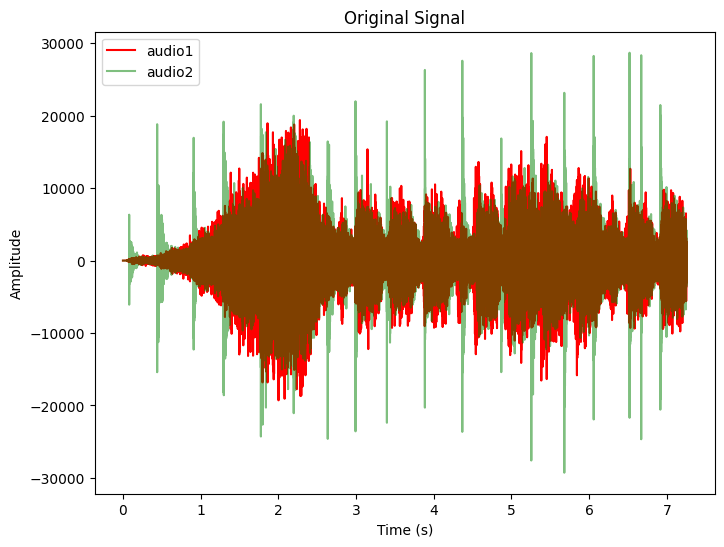

In [10]:
show_compare(FFT1.time_stamp, FFT1.data, FFT2.time_stamp, FFT2.data, "Original Signal", "Time (s)", "Amplitude")

In [11]:
FFT1.fft_operation()
FFT2.fft_operation()

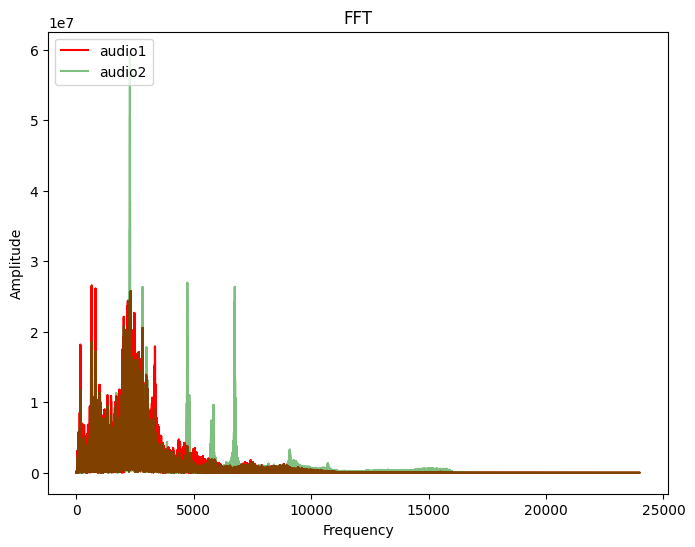

In [12]:
show_compare(FFT1.freq, FFT1.amplitude, FFT2.freq, FFT2.amplitude, "FFT", "Frequency", "Amplitude")

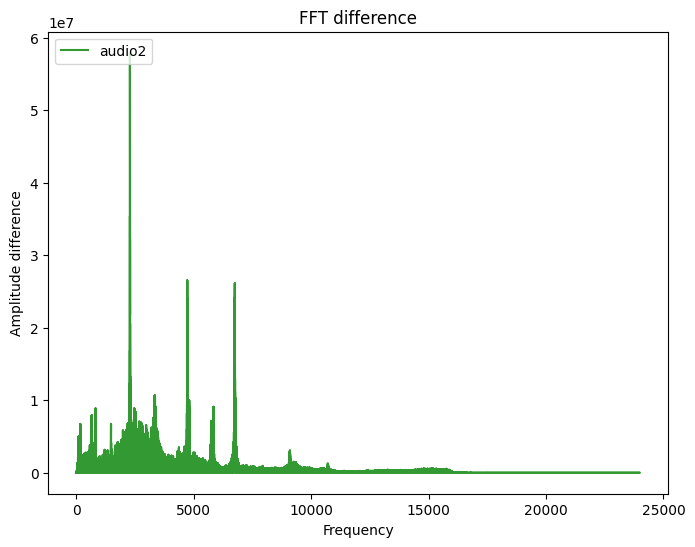

In [13]:
# Subtract the two amplitude plots
show_pic(FFT1.freq, np.abs(FFT1.amplitude - FFT2.amplitude), "FFT difference", "Frequency", "Amplitude difference")

#### In this diagram, we can clearly see that there are significant differences between the two audio at certain frequencies. I think it is obviously that we add the noise. And there are small differences in other frequencies, it may because some system errors in recording, such as differences of background sound, small difference of the time we record the music.

In [14]:
# calculate the similarity by Euclidean distance (Euclidean norm = 2)
distance = np.linalg.norm(FFT1.amplitude - FFT2.amplitude)
distance = distance // len(FFT1.freq)
print("Distance between the two audio signals:", distance)

Distance between the two audio signals: 1616.0


### Another thinking: calculate the distance after filter the noise

In [15]:
FFT1.filter_operation()
FFT2.filter_operation()

/home/feifan/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


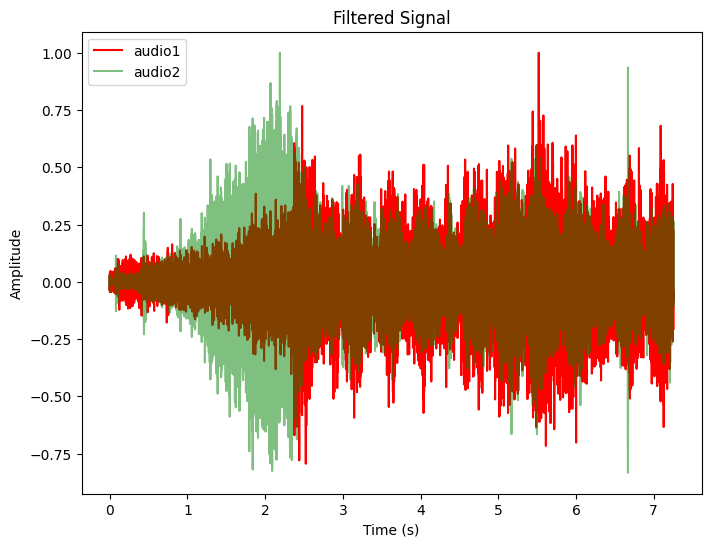

In [16]:
show_compare(FFT1.time_stamp, FFT1.normalized_sig, FFT2.time_stamp, FFT2.normalized_sig, "Filtered Signal", "Time (s)", "Amplitude")